In [2]:
import numpy as np
import pandas as pd
import os
import pandasql
from pandasql import sqldf
from matplotlib import pyplot as plt
import seaborn as sns
import string
import gzip
%matplotlib inline

In [3]:
pysqldf = lambda q: sqldf(q, globals())

# Q7 Who are some persons of interest that we'd consider working with?

In [6]:
with gzip.open("cleaneddata/imdb_principal_main.csv.gz") as obj:
    principals_df = pd.read_csv(obj)
principals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 14 columns):
Unnamed: 0            1028186 non-null int64
tconst                1028186 non-null object
ordering              1028186 non-null int64
nconst                1028186 non-null object
category              1028186 non-null object
job                   177684 non-null object
characters            393360 non-null object
primary_name          1027912 non-null object
birth_year            234048 non-null float64
death_year            11843 non-null float64
primary_profession    974266 non-null object
known_for_titles      997445 non-null object
averagerating         629755 non-null float64
numvotes              629755 non-null float64
dtypes: float64(4), int64(2), object(8)
memory usage: 109.8+ MB


In [7]:
imdb_main_df = pd.read_csv("cleaneddata/imdb_main_table.csv")
imdb_main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36870 entries, 0 to 36869
Data columns (total 14 columns):
Unnamed: 0         36870 non-null int64
title_id           36870 non-null object
ordering           36870 non-null int64
region             36870 non-null object
language           21110 non-null object
directors          36739 non-null object
writers            33395 non-null object
primary_title      36870 non-null object
original_title     36870 non-null object
start_year         36870 non-null int64
runtime_minutes    34964 non-null float64
genres             36663 non-null object
averagerating      36870 non-null float64
numvotes           36870 non-null int64
dtypes: float64(2), int64(4), object(8)
memory usage: 3.9+ MB


In [6]:
# Removes rows with absent primary names
principals_df = principals_df[principals_df['primary_name'].notna()]

In [7]:
principals_df.head()

,Unnamed: 0,tconst,ordering,nconst,category,job,characters,primary_name,birth_year,death_year,primary_profession,known_for_titles,averagerating,numvotes
0,0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]",Tommy Dysart,NaN,NaN,actor,"tt0093120,tt0076974,tt0084296,tt0077064",NaN,NaN
1,1,tt0111414,2,nm0398271,director,NaN,NaN,Frank Howson,1952.0,NaN,"actor,writer,producer","tt0104271,tt0094789,tt0102076,tt0111414",NaN,NaN
2,2,tt0111414,3,nm3739909,producer,producer,NaN,Barry Porter-Robinson,NaN,NaN,"producer,art_department","tt0290884,tt0101374,tt0111414,tt1566940",NaN,NaN
3,3,tt0323808,10,nm0059247,editor,NaN,NaN,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director","tt0402910,tt1022883,tt0086190,tt0490181",3.9,2328.0
4,4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]",Brittania Nicol,NaN,NaN,"actress,soundtrack",tt0323808,3.9,2328.0


In [8]:
principals_df = principals_df[principals_df['averagerating'].notna()]

In [9]:
principals_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629598 entries, 3 to 1028175
Data columns (total 14 columns):
Unnamed: 0            629598 non-null int64
tconst                629598 non-null object
ordering              629598 non-null int64
nconst                629598 non-null object
category              629598 non-null object
job                   124945 non-null object
characters            248025 non-null object
primary_name          629598 non-null object
birth_year            179923 non-null float64
death_year            8232 non-null float64
primary_profession    606622 non-null object
known_for_titles      621235 non-null object
averagerating         629598 non-null float64
numvotes              629598 non-null float64
dtypes: float64(4), int64(2), object(8)
memory usage: 72.1+ MB


In [10]:
rising_star_df = pd.merge(left=principals_df, right= imdb_main_df[['title_id','start_year','primary_title','genres']],\
                          left_on='tconst', right_on='title_id', how='inner')
rising_star_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333612 entries, 0 to 333611
Data columns (total 18 columns):
Unnamed: 0            333612 non-null int64
tconst                333612 non-null object
ordering              333612 non-null int64
nconst                333612 non-null object
category              333612 non-null object
job                   77710 non-null object
characters            128069 non-null object
primary_name          333612 non-null object
birth_year            121087 non-null float64
death_year            4816 non-null float64
primary_profession    324275 non-null object
known_for_titles      330242 non-null object
averagerating         333612 non-null float64
numvotes              333612 non-null float64
title_id              333612 non-null object
start_year            333612 non-null int64
primary_title         333612 non-null object
genres                331980 non-null object
dtypes: float64(4), int64(3), object(11)
memory usage: 48.4+ MB


Here we splice the dataframe to have the characteristics we need it to have. We need our rising stars to have been a part of a movie in the last 5 years, to have had it been successful in terms of ratings, on a 10 point scale, at least a 8.0, and for that film to have recieved a notable amount of reviews.

In [11]:
rising_star_df = rising_star_df[(rising_star_df['start_year']>=2015)\
                                &(rising_star_df['averagerating']> 8.0)\
                                &(rising_star_df['numvotes']>30)]

## Our rising stars will have more than one feature or film they are associated with. We will sort and group even further.

In [12]:
rising_grouped = rising_star_df[['nconst','averagerating','numvotes']].groupby('nconst').agg(['count','mean'])
rising_grouped = rising_grouped[(rising_grouped['averagerating']['count']>2)\
                                &(rising_grouped['averagerating']['mean']<9.0)\
                                &(rising_grouped['numvotes']['mean']>300)].reset_index()

In [13]:
rising_grouped

nconst averagerating           numvotes               
                      count      mean    count           mean
0   nm0000138             3  8.700000        3   10294.000000
1   nm0000636             3  8.433333        3     652.666667
2   nm0007123             3  8.800000        3    5245.666667
3   nm0598531             3  8.233333        3   10086.666667
4   nm0749263             3  8.466667        3  492390.333333
5   nm1335704             3  8.600000        3    2328.666667
6   nm1940449             3  8.666667        3  122493.666667
7   nm2690647             3  8.300000        3    8745.333333
8   nm3606487             3  8.700000        3    8192.666667
9   nm3909481             3  8.300000        3    3771.000000
10  nm4043111             4  8.600000        4    8567.000000
11  nm4272786             3  8.300000        3    3771.000000
12  nm4584004             3  8.466667        3    1956.000000
13  nm4921260             3  8.333333        3    4081.000000
14  nm5787869             3  8.233333        3   16962.333333

### This group of people have films that are well liked, with some being popular

In [14]:
final_form_df = pd.merge(left=rising_grouped['nconst'],\
                         right=rising_star_df[['category','primary_name','primary_title','genres','nconst','averagerating','numvotes']],\
                        on='nconst', how='inner')

In [15]:
final_form_df

,nconst,category,primary_name,primary_title,genres,averagerating,numvotes
0,nm0000138,self,Leonardo DiCaprio,Before the Flood,"Documentary,News",8.3,23264.0
1,nm0000138,actor,Leonardo DiCaprio,Once Upon a Time ... in Hollywood,"Comedy,Drama",9.7,5600.0
2,nm0000138,producer,Leonardo DiCaprio,Struggle: The Life and Lost Art of Szukalski,Documentary,8.1,2018.0
3,nm0000636,writer,William Shakespeare,Hamlet,Drama,8.6,1587.0
4,nm0000636,writer,William Shakespeare,Branagh Theatre Live: Romeo and Juliet,Romance,8.1,236.0
5,nm0000636,writer,William Shakespeare,National Theatre Live: King Lear,Drama,8.6,135.0
6,nm0007123,actor,Mammootty,Pathemari,Drama,8.4,3195.0
7,nm0007123,actor,Mammootty,Yatra,"Biography,Drama",8.6,2913.0
8,nm0007123,actor,Mammootty,Peranbu,Drama,9.4,9629.0
9,nm0598531,writer,Mark Monroe,Racing Extinction,"Adventure,Documentary,Drama",8.2,6931.0


### The majority of the actors and films here are of a very distinct cinema group, Malayalam, which will all be in that language and from what I've been able to gather, not likely exported. We are switching our focus to actors  who's films have been very well recieved.

Three stand out: Mark Ruffalo, Andrew Garfield, and Mark Monroe (writer)

In [16]:
actors_to_consider_df = final_form_df[(final_form_df['primary_name'] == 'Mark Ruffalo')\
                                        |(final_form_df['primary_name'] == 'Andrew Garfield')]


In [17]:
actors_to_consider_df

,nconst,category,primary_name,primary_title,genres,averagerating,numvotes
12,nm0749263,actor,Mark Ruffalo,Spotlight,"Crime,Drama",8.1,365110.0
13,nm0749263,actor,Mark Ruffalo,Avengers: Endgame,"Action,Adventure,Sci-Fi",8.8,441135.0
14,nm0749263,actor,Mark Ruffalo,Avengers: Infinity War,"Action,Adventure,Sci-Fi",8.5,670926.0
18,nm1940449,actor,Andrew Garfield,Hacksaw Ridge,"Biography,Drama,History",8.1,366904.0
19,nm1940449,actor,Andrew Garfield,National Theatre Live: Angels in America Part ...,Drama,8.9,325.0
20,nm1940449,actor,Andrew Garfield,National Theatre Live: Angels in America Part ...,Drama,9.0,252.0


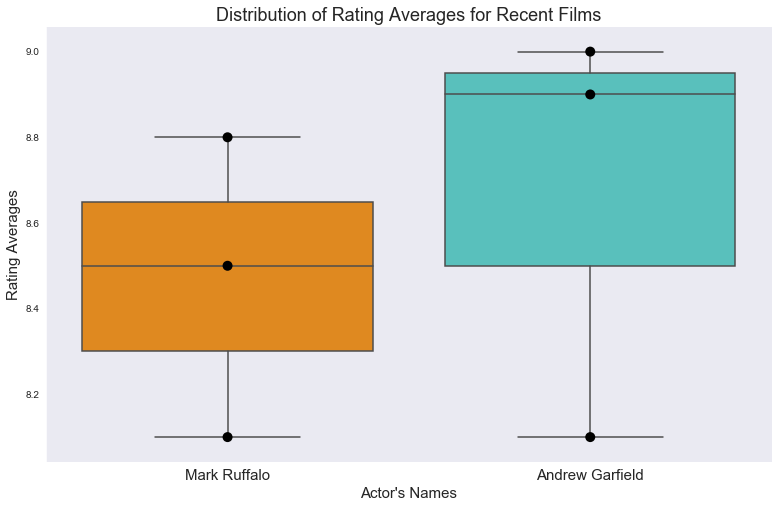

In [18]:
plt.figure(figsize=(13,8))
sns.set_style("dark")

fig14 = sns.boxplot(x='primary_name', y='averagerating',data=actors_to_consider_df, palette=['darkorange','mediumturquoise'])

fig15 = sns.swarmplot(x='primary_name', y='averagerating', data=actors_to_consider_df, color='k',size=10)
sns.despine()
plt.xlabel("Actor's Names",size=15)
fig14.set_xticklabels(labels=fig14.get_xticklabels(), fontdict={'fontsize':15})
plt.ylabel('Rating Averages', size=15)
plt.title("Distribution of Rating Averages for Recent Films",size=18)
plt.show()